# Data processing 
Chose the hyperparameters of the model

Select the "GPU" or "CPU" for training

Download the images that will be used to train and validate the model

Normalize and put the images in a data loader for easier manipulation

Show a few of the images and their labels to confirm that the operations have been successfully executed

In [197]:
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

In [198]:
batch_size = 32
lr = 0.01
momentum = 0.9
epochs = 10

In [199]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [200]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/test')

In [201]:
def create_dataloader(path, train, batch=batch_size, shuffle=True):
    transformations = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(0.5, 0.5)])

    data = torchvision. datasets.MNIST(path, train=train, download=True, transform=transformations)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch, shuffle=shuffle)
    return dataloader

In [202]:
train_dataloader = create_dataloader("./data", True)
val_dataloader = create_dataloader("./data", False)

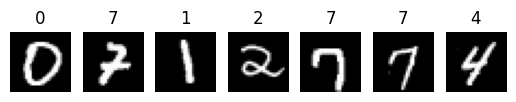

In [203]:
def show_img(nr_img=7):
    fig, ax = plt.subplots(1, nr_img)
    
    images, labels = next(iter(train_dataloader))
    
    for idx, image in enumerate(images[:nr_img]):
        ax[idx].set_title(int(labels[idx]))
        ax[idx].imshow(image[0], cmap="gray")
        ax[idx].axis("off")

    plt.show()
    writer.add_figure("Sample input", fig)
    return images.to(device)
    
images = show_img()

# Create model
Create a MLP model using the PyTorch library.

Create an optimizer and a loss function to update the weights of the model

In [204]:
import torch.nn as nn
import torch.nn.functional as F

In [205]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 150)
        self.fc3 = nn.Linear(150, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

writer.add_graph(net, images)
writer.close()

In [206]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

# Train and Validate the model
Train the model using the training data that has been generated in the previous steps 

Use the validation data to test for overfitting.

Record the loss and accuracy of the model using tensorboard.

Save the best and the last model after training.

In [207]:
def count_predictions(outputs, labels, correct_pred, total_pred):

    predictions = torch.argmax(outputs, 1)

    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[label] += 1
        total_pred[label] += 1

    return correct_pred, total_pred

In [208]:
def compute_accuracy(correct_pred, total_pred, name, epoch):

    class_accuracy = 100 * correct_pred / total_pred
    global_accuracy = 100 * sum(correct_pred) / sum(total_pred)

    writer.add_scalar(f"{name} Global Accuracy", global_accuracy, epoch)
    writer.add_scalars(f"{name} Class Accuracy", {f"number-{i}": acc for i, acc in zip(range(10), class_accuracy)}, epoch)

In [209]:
def save_predictions(images, net_outputs, labels, epoch, nr_img=7):
    fig, ax = plt.subplots(1, nr_img)
    
    conf, pred = torch.max(F.softmax(net_outputs, 1), 1)
    for idx, image in enumerate(images[:nr_img]):
        
        ax[idx].set_title(f"{round(float(conf[idx].cpu()) * 100, 2)}% \n Pred: {int(pred[idx].cpu())} \n Label: {int(labels[idx].cpu())}", 
                          color=("green" if pred[idx]==labels[idx] else "red"))
        
        ax[idx].imshow(image.cpu()[0], cmap="gray")
        ax[idx].axis("off")

    writer.add_figure("predictions", fig, epoch)

In [210]:
def validate_model(epoch):
    net.eval()

    correct_pred = np.zeros(10)
    total_pred = np.zeros(10)

    val_loss = 0  
    for data in val_dataloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        correct_pred, total_pred = count_predictions(outputs, labels, correct_pred, total_pred)

    save_predictions(images, outputs, labels, epoch)
    writer.add_scalar("Validation Loss", val_loss / len(val_dataloader), epoch)
    compute_accuracy(correct_pred, total_pred, "Validation", epoch)
    
    return val_loss / len(val_dataloader)

In [211]:
def train_model(epoch):
    net.train(True)

    correct_pred = np.zeros(10)
    total_pred = np.zeros(10)

    train_loss = 0
    for idx, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
    
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        correct_pred, total_pred = count_predictions(outputs, labels, correct_pred, total_pred)

    writer.add_scalar("Training Loss", train_loss / len(train_dataloader), epoch)
    compute_accuracy(correct_pred, total_pred, "Training", epoch)

In [212]:
def main():
    best_loss = np.inf
    for epoch in tqdm(range(epochs)):

        train_model(epoch)
        curr_loss = validate_model(epoch)

        if curr_loss < best_loss:
            best_loss = curr_loss
            torch.save(net, "best.pt")
            
        torch.save(net, "last.pt")

if __name__ == "__main__":
    main()

100%|██████████████████████████████████████████| 10/10 [06:22<00:00, 38.23s/it]
